# <center> Pipeline to download and preprocess public satellite imagery </center>


The goal of this notebook is to solve 2 problems:
1. Download images from free satellite imagery providers (ESA's Sentinel program, NASA's Landsat program) with Python
2. Preprocess (compute RGB, NDVI, other remote sensing indices) and resize images so that they are in good shape to train a DL model

We will run experiments in this notebook and write python modules covering these 2 steps programmaticaly.

## Explorations

### Available imagery

* Public data

The most commonly used sources of satellite imagery are the US program Landsat and the European program Sentinel. Satellites from these programs, in particular Landsat 5-7-8 and Sentinel 2A-2B, provide imagery of all land on earth on a very regular basis (repeat time under 5 days for most places). Sentinel 2A-2B and Landsat 7-8 are still active, while Landsat 5 was discontinued in 2013 but can still provide precious historical data back until 1984.

The images come with several spectral bands (13 for Sentinel-2, 9 for Landsat), in resolutions from 10m to 60m per pixel, as described below:
<br>
<img src="https://www.researchgate.net/profile/Lauri_Korhonen/publication/316644351/figure/tbl1/AS:753655984701441@1556696997414/Spectral-bands-and-resolutions-of-Landsat-8-OLI-and-Sentinel-2-MSI-sensors-70.png" alt="bands" width="600"/>
<br>
The Landsat images are available in 3 "tiers", corresponding to quality - "Real-time" images, which is raw data to monitor ongoing natural events, "Tier 1", which is calibrated high-quality data, and "Tier 2", which is lower quality data (lots of clouds, calibrating errors, etc.). For analysis, we will preferably use Tier 1.

Similarly, Sentinel-2 offers several tiers: the 2 top qualities, available for users, are "Level 1-C", which corresponds to ortho-rectified TOA (top of atmosphere) reflectance, available from 2015-06-23, and "Level 2-A", which looks very similar and corresponds to ortho-rectified BOA (bottom of atmosphere) reflectance or "SR" (surface reflectance), available from 2017-03-28.

As source images are very large (185x180 km for Lansat, 100x100 km for Sentinel-2), in addition to spectral band processing we will need to crop the images to our areas of interest for easier manipulation.

* Private data

There are several private companies operating satellites and providing access to optical imagery with a monthly subscription, including Planet, Mapbox and DigitalGlobe. Data can be more precise than Sentinel or Landsat (resolution up to under 1m), but you have to pay the price.

* Other sources

Some governments or administrations (cities, etc.) sometimes open-source datasets covering a special area or for special purposes - before starting a project it's a good idea to check online if anything is available beforehand.

### Available tools

* Cloud storage

Public satellite data is stored as file collections in Google Cloud Platform and Amazon Web Services. It can be accessed through the specific platform interface, or downloaded directly if you know the folder structure and request a correct image URL.

Google Earth Engine also offers a programatic interface to download and process Sentinel and Landsat data.

* Web APIs

The USGS data hub and the Copernicus or PEPS platforms (respectively for Landsat and Sentinel-2 data) offer a web API to download images. Some private companies also interface with the image sources and offer a custom platform, such as Sentinel-hub's "EO browser" (Slovenian company), or spectator.earth (Polish company).

* Python APIs

These are, in my opinion, the most simple tools to download public satellite imagery. There are several python packages to connect to Copernicus or USGS and download data (respectively `sentinelsat` and `landsat-util`, but these tools offer very few processing options. An efficient low-level tool is also Google Earth Engine's `ee` package, but again, not enough options. There is also a very good library in R called `sen2r`, with a nice R-Shiny interface, published earlier in 2020 - but this is another language.

$\rightarrow$ This is why I developed a custom python package named `totalsat`, to download and preprocess public satellite imagery through a smooth pipeline. See details and demo in the next section!

### Custom tool: `totalsat`

`totalsat` is based on the `ee` library for image access, and on `gdal` and `skimage` for image processing. It contains (for now) 3 modules: `sat_download`, `sat_preprocess` and `sat_tools` (utils module), with each time several functions to solve our initial problems.

Most of the code I used comes from a great open-source python library published only a few weeks ago (University of New South Wales, Australia, 2020), named `coastsat` ([link](https://github.com/kvos/CoastSat)). Next to modules related to coastline monitoring, it provided modules to download and process Landsat and Sentinel-2 images, which I customized and augmented in order to fit Total's needs.

## Pipeline demo

In [1]:
# notebook imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import folium
import rasterio
from rasterio import plot
import shapely
import warnings
warnings.filterwarnings("ignore")

# totalsat imports
sys.path.insert(0, '..') # move to parent directory
from totalsat import sat_download, sat_preprocess, sat_tools

In /Users/Thomas/opt/anaconda3/envs/totalsat/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/Thomas/opt/anaconda3/envs/totalsat/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/Thomas/opt/anaconda3/envs/totalsat/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### Check availability of images

The first step in our pipeline is to check image availability based on a list of criteria. 

These criteria are passed as a dictionary into the `sat_download.check_images_available` function. It can include:
* coordinates of the region to download (either a polygon or a point + radius in km, max: 50)
* date range (by default, the last week)
* chosen satellites (among Sentinel-2 and Landsat 5-7-8)
* max cloud cover percentage (by default, 75%)
* max image size, in pixels (which allows to split the original area of interest into smaller tiles)

The function will browse through the Google Earth Engine collections for Sentinel-2 Level-1C images and Landsat Tier 1 and Tier 2 images (option available to look into Tier 2 as well) and will print the number of images available for the user inputs.

In [26]:
inputs = {'sat_list': ['S2'],
          'dates': 'last',
          'point': [-1.0107, 44.0027],
          'radius': 25,
          'max_cloud_cover': 5,
          'filepath': '../data',
          'sitename': 'tree_storage_search',
          'max_size': 256,
          'include_T2': False,
          'merge': False
         }

In [27]:
im_dict_T1, im_dict_T2 = sat_download.check_images_available(inputs);

Looking for the last available image...
Your area of interest will be split into smaller image areas to fit max_size requirements.
Searching for images on the GEE server...

- In Landsat Tier 1 & Sentinel-2 Level-1C / Level 2-A:
  S2: 400 image(s)
  Total: 400 image(s) selected.


In [7]:
len(im_dict_T1['S2'])

16

In [8]:
len(inputs['polygons_list'])

16

With another function, we can plot the requested area on an interactive `folium` map. The layer control toggle allows to switch from map to satellite view and to visualize the area split.

In [28]:
sat_download.plot_requested_area(inputs)

### Download images

The function `sat_download.retrieve_images(inputs)` retrieves the satellite images from Google Earth Engine. It downloads only the cropped area of interest, and saves it as a .tif file in a folder defined as input (`filepath`
\+ `sitename`). 1 folder will be created per satellite, as well as 1 folder to store a json file metadata for each 10m multispectral image in a text file.

The function also automatically removes potential image duplicates and merges overlapping images (if your area of interest is under 2 different satellite passes). The output of the function is a dictionary containing the metadata of each downloaded image.

In case you need to access Landsat Tier 2 images, you can set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [10]:
metadata = sat_download.retrieve_images(inputs)

Looking for the last available image...
Your area of interest will be split into smaller image areas to fit max_size requirements.
Searching for images on the GEE server...

- In Landsat Tier 1 & Sentinel-2 Level-1C / Level 2-A:
  S2: 16 image(s)
  Total: 16 image(s) selected.

S2: 16 image(s)
100%

If you have already downloaded the images earlier, you can just reload the metadata files by running the function below:

In [11]:
metadata = sat_download.get_metadata(inputs)

In [12]:
metadata

{'S2': {'filenames': ['2020-05-31-11-18-06_S2_Sea_10m_16-52-02.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-09.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-16.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-22.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-29.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-36.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-44.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-52-53.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-00.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-06.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-12.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-20.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-27.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-32.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-38.tif',
   '2020-05-31-11-18-06_S2_Sea_10m_16-53-45.tif'],
  'acc_georef': [-1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0],
  'epsg': [32630,
   

### Preprocess images

Each downloaded image contains several unprocessed spectral bands stacked on top of each other, such as the image will first appear as grayscale. The `sat_preprocess` module allows you to create an RGB image or other remote sensing indices (NDVI, BSI, etc. - 7 pre-coded indices available).

The main preprocessing function is `sat_preprocess.save_files`. It takes as input the metadata of the downloaded images, the `inputs` dictionary and the `formula` the user wants to apply (among RGB, NDVI, BSI and various other remote sensing indices). Spectral bands are rescaled, pansharpened (for Landsat) and a cloud mask (black pixels) is applied to each final image.

The preprocessed images are then saved as georeferenced TIF files (if you choose "RGB") or as simple JPG files (if you choose another formula) in a separate folder (named "/preprocessed_files/RGB", or the chosen index name). In the case of remote sensing indices, the images are written as 1-channel only, with a colormap treatment that can be specified in the optional `colormap` argument (default: matplotlib's "summer" palette).

In [10]:
sat_preprocess.save_files(metadata, inputs, formula='[ RGB ]')

Starting preprocessing as RGB...
100%
RGB satellite images saved in ../data/Demo2/preprocessed_files/RGB


We can check with `rasterio` that the metadata from the newly written image was maintained:

In [6]:
example = '../data/Demo/preprocessed_files/RGB/2020-05-25-10-58-45_S2_Demo_10m_22-15-33_S2_RGB.tif'
with rasterio.open(example) as src:
    meta = src.meta
    image = src.read()

In [7]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 2051,
 'height': 2049,
 'count': 3,
 'crs': CRS.from_epsg(32631),
 'transform': Affine(10.0, 0.0, 329650.0,
        0.0, -10.0, 4895180.0)}

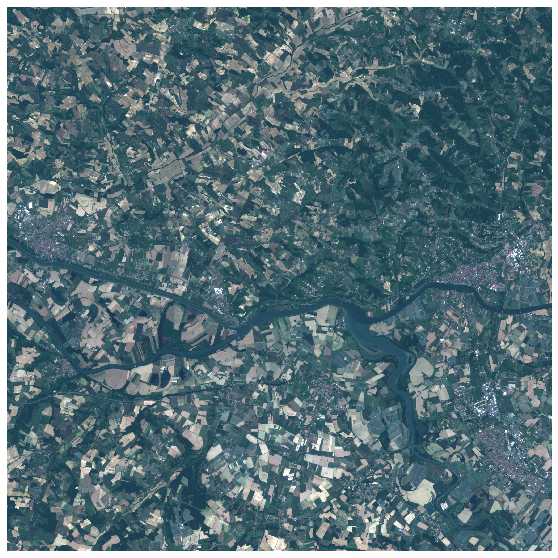

In [15]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(rasterio.plot.reshape_as_image(image))
plt.show()

We can also compute the NDVI (Normalized Difference Vegetation Index, showing vegetation health) and NDWI (Normalized Difference Water Index, showing image water content), using different colormaps for visualizations (see list of possible colormaps [here](https://matplotlib.org/examples/color/colormaps_reference.html)).

In [5]:
sat_preprocess.save_files(metadata, inputs, formula='[ NDVI ]')

Starting preprocessing as NDVI...
100%
NDVI satellite images saved in ../data/Demo/preprocessed_files/NDVI


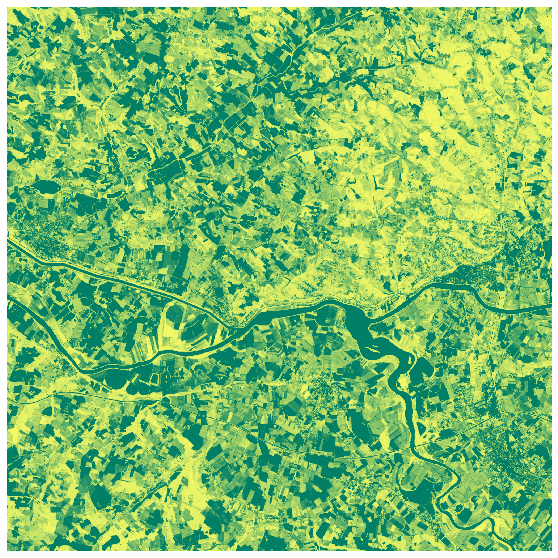

In [8]:
img = plt.imread('../data/Demo/preprocessed_files/NDVI/2020-05-25-10-58-45_S2_Demo_10m_22-15-33_S2_NDVI.png')
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

In [9]:
sat_preprocess.save_files(metadata, inputs, formula='[ NDWI ]', colormap='winter')

Starting preprocessing as NDWI...
100%
NDWI satellite images saved in ../data/Demo/preprocessed_files/NDWI


In [31]:
sat_preprocess.save_files(metadata, inputs, formula='[ NDWI ]', colormap='winter')

Starting preprocessing as NDWI...
100%
NDWI satellite images saved in ../data/Test/preprocessed_files/NDWI


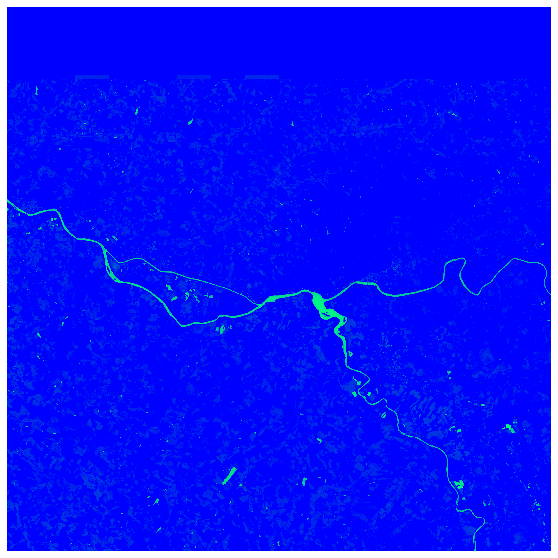

In [32]:
img = plt.imread('../data/Test/preprocessed_files/NDWI/2020-05-25-10-58-59_S2.png')
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

Last, but not least, we can compute any band combination using a custom formula. 

Valid combinations are of the form: [ R * 0.5 , NIR * 1 , B * 0.7 ]. Make sure you add spaces everywhere for the parser to understand the formula. Coefficients correspond to pixel intensity (in %). The first band will be interpreted as Red channel, the 2nd one as Green channel, and the 3rd one as Blue channel. This way, we can experiment, use false colors, adjust color intensity, etc... let's get creative!

You can see more details and examples of "custom scripts" through this [link](sentinel-hub.com/sites/default/Custom_script_tutorial.pdf).

In [6]:
sat_preprocess.save_files(metadata, inputs, formula='[ R * 1 , NIR * 0.5 , B * 0.7 ]')

Starting preprocessing as R*1,NIR*0.5,B*0.7...
100%
R*1,NIR*0.5,B*0.7 satellite images saved in ../data/Demo/preprocessed_files/custom_formula


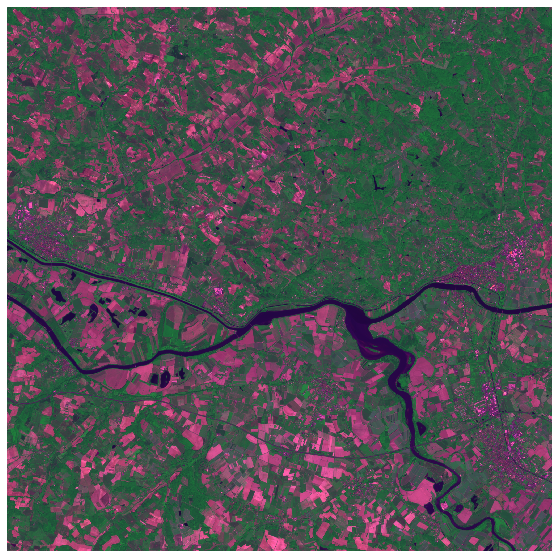

In [8]:
img = plt.imread('../data/Demo/preprocessed_files/custom_formula/2020-05-25-10-58-45_S2_Demo_10m_22-15-33_S2_R*1,NIR*0.5,B*0.7.tif')
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

### Split images

The `split_image` function from `sat_tools` can finally be used to split an image in smaller tiles if needed. Tiles are saved as PNG, which doesn't maintain metadata (as PNGs, contrary to TIFs, aren't georeferenced images).

The number of tiles depends either on a custom `nb_tiles` argument or on a `max_tile_size` argument (as in the example below). Tiles follow by default the image aspect ratio, but can be set to square shape with the `square` argument. They are automatically numbered and saved in a chosen `filepath_out` folder, or by default in a "/split_tiles" folder next to the other directory defined earlier in earlier preprocessing steps (based on the `inputs` dictionary).

In [5]:
image_path = '../data/Demo/preprocessed_files/RGB/2020-05-25-10-58-45_S2_Demo_10m_22-15-33_S2_RGB.tif'

Splitting the original image in 16 tiles of size 512x512...
Tiles successfully saved in ../data/Demo/preprocessed_files/split_tiles.


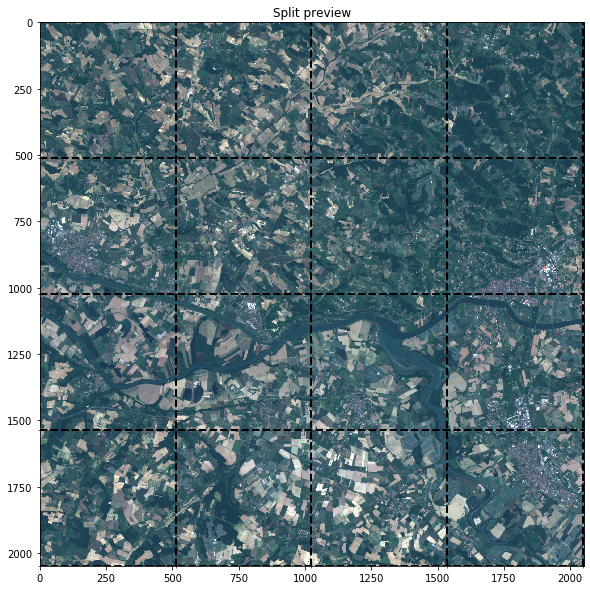

In [6]:
sat_tools.split_image(image_path, square=True, max_tile_size=512*512, inputs=inputs, show=True)

We can finally just check one of the small tiles:

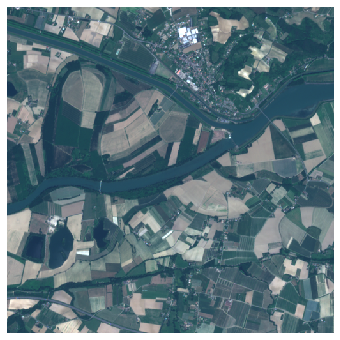

In [7]:
img = plt.imread('../data/Demo/preprocessed_files/split_tiles/2020-05-25-10-58-45_S2_Demo_10m_22-15-33_S2_RGB_03_02.png')
plt.figure(figsize = (6,6))
plt.axis('off')
plt.imshow(img)
plt.show()

### Create timelapse

For fun or for study, another option is to save a timelapse video (.mp4) of images corresponding to a chosen period. The video is saved in the Google Drive linked to the user's GEE account. Available images are Landsat 5 (03/1984 - 05/2013), Landsat 7 (04/1999 - present, but several system failures make Landsat 8 a preferred choice when possible), and Landsat 8 (06/2013 - present).

TODO: 1) download video directly on disk, 2) add Sentinel-2 and MODIS, 3) add remote sensing indices timelapse, 4) merge sources if dates spans over several satellite periods.

The function from `totalsat` works as it is, but to create better timelapses with text overlays and many other great options that are not implemented here, you can refer to the awesome `geemap` package: https://github.com/giswqs/geemap.

In [9]:
timelapse_settings = {'sat': 'L5',
                      'dates': ['1991-05-25', '2001-06-02'],
                      'point': [-122.7286, 37.6325],
                      'radius': 30,
                      #'bbox': bbox,
                      'max_cloud_cover': 20,
                      'bands': ['R', 'SWIR1', 'B'],
                      'filename': 'timelapse_demo',
                      'frames_per_sec': 12,
                      'video_dim': 720
                      }

In [ ]:
sat_tools.timelapse(sat, start_date, end_date, max_cloud_cover, bands, filename,
                      bbox=None, point=None, radius=None, correct_path_row=False,
                      video_dim=720, frames_per_sec=12)

### Annotate images

Finally, the `annotate_images` function from the `sat_tools` module, associated with `%matplotlib qt` linemagic command, allows us to directly label images (i.e. create polygon annotations) in a notebook through an interactive matplotlib console. The polygons can then be used (for example) to create object detection masks.

You can pass to the function either the inputs dictionary from `sat_downlaod` and `sat_preprocess`, or the path to a folder with images to annotate. For now, the function works only with georeferenced images (i.e. .tif format). Images can have 1, 3 or 4 channels (grayscale index, RGB or RGB-A). The polygon annotations will be saved in the same folder as the images, in .geojson and .pkl formats. The polygon coordinates are saved in both pixel coordinates (to be able to create masks) and in a chosen coordinate reference system (which can be passed in the `output_epsg` argument - by default, epsg:4326).

In [2]:
inputs = {'sat_list': ['S2'],
          'dates': 'last',
          'point': [1.0, 44.1],
          'radius': 10,
          'max_cloud_cover': 10,
          'filepath': '../data/',
          'sitename': 'Demo',
          'max_size': 512,
          'include_T2': False,
          'merge': False
         }

In [3]:
metadata = sat_download.get_metadata(inputs)

In [9]:
%matplotlib qt

labels = sat_tools.annotate_images(source='../data/WIP/Quadran/preprocessed_files/RGB', label_type='polygon')

ValueError: A LinearRing must have at least 3 coordinate tuples

In [3]:
labels

image_name  label
0  2020-05-25-10-58-45_S2_Demo_10m_22-15-33_S2_R*...  False
1  2020-05-30-10-58-50_S2_Demo_10m_22-15-56_S2_R*...   True

In [3]:
labels

[array([[ 0.98243749, 44.15601658,  0.        ],
        [ 1.04665594, 44.15480994,  0.        ],
        [ 1.00170331, 44.11634582,  0.        ],
        [ 0.92908092, 44.13363704,  0.        ]]),
 array([[ 1.03230748, 44.1442386 ,  0.        ],
        [ 1.08899777, 44.14262004,  0.        ],
        [ 1.03862969, 44.11569534,  0.        ]])]

Finally, you can use the `plot_labels` function to check the polygon labels on an interactive satellite map. You can pass to the function either the list of polygon coordinates outputted by `annotate_images`, or a list of polygon coordinates (`(lon,lat)` format) extracted from a .geojson file.

In [4]:
sat_tools.plot_labels(labels)

### Reverse geocoding

Reverse geocoding is the task of getting an address from `(lat,lon)` coordinates. For example, after we have downloaded image tiles, we can get the coordinates of the image center with the `sat_tools.get_image_centroid` function, and then get the corresponding address with the `sat_tools.get_address` function.

The `get_address` function uses the `geopy` package and the Nominatim API (by OSM) to get the raw address, and then lets the user specify a custom address parsing. Possible arguments under `parsing` are: 'full_address_str' (default - the full address as a DataFrame), 'full_address_str' (full address as a string), and one or several keys among: `['country', 'state', 'county', 'postcode', city', 'road', 'house_number']`. Available keys depend on OSM information for the specified location, and if the chosen keys aren't available the function will fill the blank with a NaN.

In this use case, we apply the `get_address` function to all positive image tiles in order to get the corresponding village name.

## Next steps

The downloading and preprocessing pipeline successfully works - however the package still needs a little debugging to run perfectly clean, especially in order to split the area of interest before downloading images (which is important to maintain metadata and to be able to define georeferenced object masks). We're almost done!

Regarding the trees project, we can now download images in areas marked as relevant by Quadran for model training, preprocess them and pass them into deep learning models for object detection or other purposes.